In [28]:
from bmtool.analysis import spikes, lfp

config_path = '/home/gjgpb9/cortex_modeling/V1_Layer5/Model-Parameters/simulation_config_baseline.json'
output_path = '../network_to_analysis/long'
fs = 400

df = spikes.load_spikes_to_df(spike_file=f'{output_path}/spikes.h5',network_name='cortex',config=config_path)
spike_rate = spikes.get_population_spike_rate(df,config=config_path,fs=fs)

ecp = lfp.load_ecp_to_xarray(ecp_file=f'{output_path}/ecp.h5')
lfp_processed = lfp.ecp_to_lfp(ecp_data=ecp,downsample_freq=fs)

Grabbing first network; specify a network name to ensure correct node population is selected.



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.2436, 1.5810                                          
                                                                                                  
                             

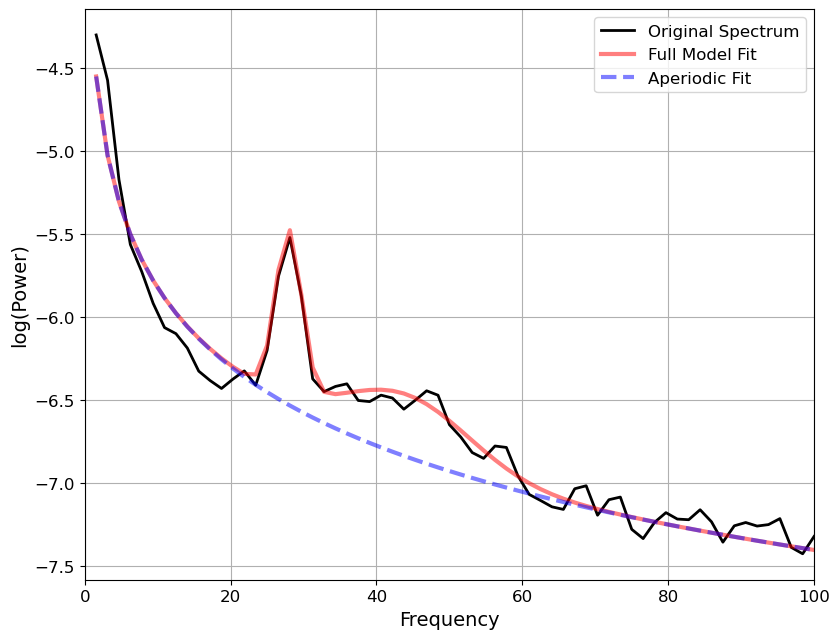

In [29]:
import scipy.signal as ss

hz, pxx = ss.welch(x=lfp_processed,fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx[0],plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.0559, 0.3389                                          
                                                                                                  
                             

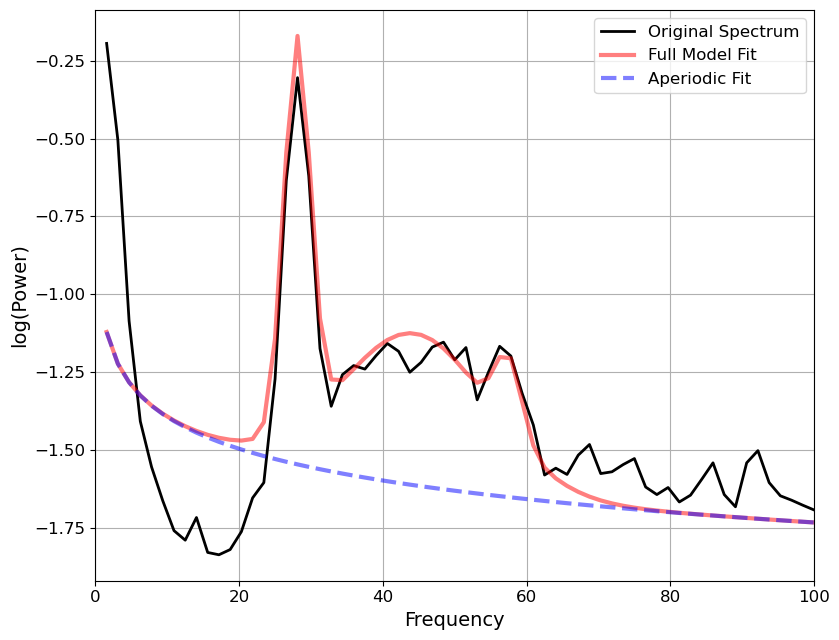

In [30]:
hz, pxx = ss.welch(x=spike_rate['FSI'],fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.5162, 0.9921                                          
                                                                                                  
                             

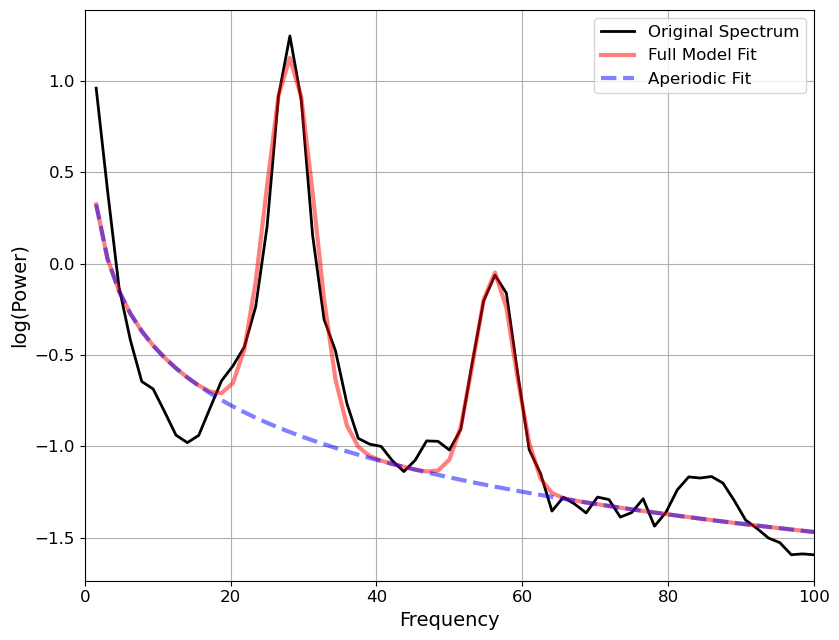

In [31]:
hz, pxx = ss.welch(x=spike_rate['LTS'],fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])

### Makes sure to change the freq_of_interest to be the center frequency of your oscillation

In [32]:
plv = lfp.calculate_plv(spike_rate['FSI'],lfp_processed[0],fs=400,freq_of_interest=27.)
print(plv)
plv = lfp.calculate_plv(spike_rate['LTS'],lfp_processed[0],fs=400,freq_of_interest=27.)
print(plv)

0.7704405300889862
0.6183596518944428


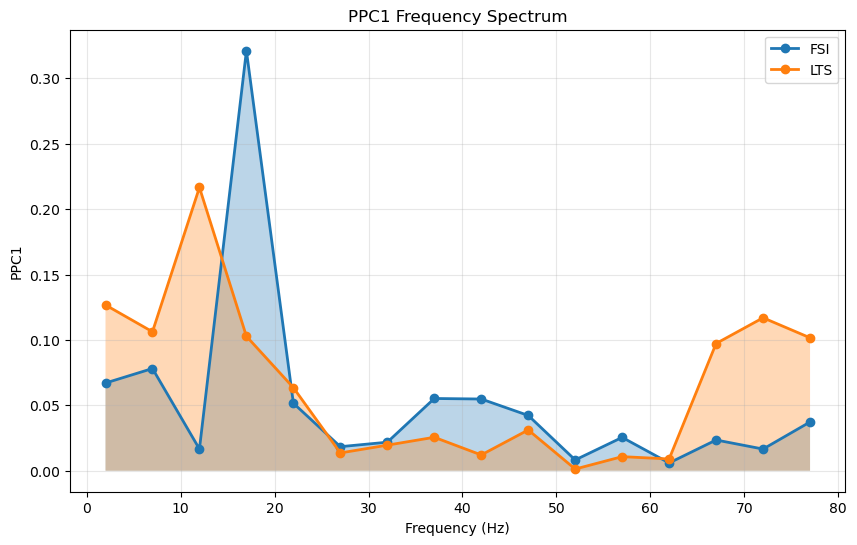

In [33]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def calculate_ppc1(spike_times, lfp_signal, fs, freq_range, window_size=0.5):
    """
    Calculate PPC1 metric between spike times and LFP signal using the vector dot product method.
    
    Parameters:
    -----------
    spike_times : array_like
        Array of spike times in seconds
    lfp_signal : array_like
        Local field potential time series
    fs : float
        Sampling frequency of the LFP signal in Hz
    freq_range : tuple
        Frequency range (low, high) to filter the LFP signal in Hz
    window_size : float, optional
        Size of the window around each spike in seconds, default is 0.5s
    
    Returns:
    --------
    ppc1 : float
        PPC1 value
    phases : array
        Phases at spike times
    """
    # Convert spike times to sample indices
    spike_indices = np.round(spike_times * fs).astype(int)
    
    # Filter LFP in the frequency band of interest
    nyquist = fs / 2
    b, a = signal.butter(3, [freq_range[0] / nyquist, freq_range[1] / nyquist], btype='band')
    filtered_lfp = signal.filtfilt(b, a, lfp_signal)
    
    # Get analytic signal through Hilbert transform
    analytic_signal = signal.hilbert(filtered_lfp)
    
    # Extract instantaneous phase
    instantaneous_phase = np.angle(analytic_signal)
    
    # Get phases at spike times
    spike_phases = []
    for spike_idx in spike_indices:
        if 0 <= spike_idx < len(instantaneous_phase):
            spike_phases.append(instantaneous_phase[spike_idx])
    
    spike_phases = np.array(spike_phases)
    
    # Calculate PPC1
    n = len(spike_phases)
    if n <= 1:
        return 0, spike_phases
    
    # Convert phases to unit vectors in the complex plane
    unit_vectors = np.exp(1j * spike_phases)
    
    # Calculate the resultant vector
    resultant_vector = np.sum(unit_vectors)
    
    # PPC1 is the squared length of the resultant vector divided by n²
    ppc1 = (np.abs(resultant_vector) ** 2) / (n ** 2)
    
    return ppc1, spike_phases

def calculate_ppc1_spectrum(spike_times, lfp_signal, fs, freq_range, freq_step, bandwidth=4):
    """
    Calculate PPC1 across a range of frequencies.
    
    Parameters:
    -----------
    spike_times : array_like
        Array of spike times in seconds
    lfp_signal : array_like
        Local field potential time series
    fs : float
        Sampling frequency of the LFP signal in Hz
    freq_range : tuple
        Frequency range (min_freq, max_freq) to analyze in Hz
    freq_step : float
        Step size between consecutive frequency bands in Hz
    bandwidth : float, optional
        Width of each frequency band in Hz, default is 4 Hz
    
    Returns:
    --------
    frequencies : array
        Center frequencies of each band
    ppc1_values : array
        PPC1 values for each frequency band
    """
    min_freq, max_freq = freq_range
    
    # Create frequency bands
    center_freqs = np.arange(min_freq, max_freq, freq_step)
    ppc1_values = []
    
    for freq in center_freqs:
        band_min = max(1, freq - bandwidth/2)  # Avoid negative frequencies
        band_max = freq + bandwidth/2
        ppc1, _ = calculate_ppc1(spike_times, lfp_signal, fs, (band_min, band_max))
        ppc1_values.append(ppc1)
    
    return center_freqs, np.array(ppc1_values)

def plot_ppc1_spectrum(frequencies, ppc1_values, ax=None, title="PPC1 Frequency Spectrum",annotate=False,label=None):
    """
    Plot PPC1 values across frequencies.
    
    Parameters:
    -----------
    frequencies : array
        Center frequencies of each band
    ppc1_values : array
        PPC1 values for each frequency band
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure and axes will be created
    title : str, optional
        Title for the plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(frequencies, ppc1_values, 'o-', linewidth=2,label=label)
    ax.fill_between(frequencies, 0, ppc1_values, alpha=0.3)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PPC1')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    # Highlight maximum PPC1 value
    max_idx = np.argmax(ppc1_values)
    max_freq = frequencies[max_idx]
    max_ppc1 = ppc1_values[max_idx]
    
    if annotate:
        ax.plot(max_freq, max_ppc1, 'ro', markersize=8)
        ax.annotate(f'Peak: {max_freq:.1f} Hz\nPPC1: {max_ppc1:.3f}',
                    xy=(max_freq, max_ppc1),
                    xytext=(max_freq+5, max_ppc1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=10)
    
    return ax


freq_range = (2, 80)  # 2-80 Hz
freq_step = 5  # 2 Hz steps
bandwidth = 10  # 4 Hz bandwidth

fig, ax = plt.subplots(figsize=(10, 6))
freqs, ppc1s = calculate_ppc1_spectrum(spike_rate['FSI'],lfp_processed[0],fs=400, freq_range=freq_range, freq_step=freq_step, bandwidth=bandwidth)
plot_ppc1_spectrum(freqs, ppc1s, title="PPC1 Frequency Spectrum",ax=ax,label='FSI')

freqs, ppc1s = calculate_ppc1_spectrum(spike_rate['LTS'],lfp_processed[0],fs=400, freq_range=freq_range, freq_step=freq_step, bandwidth=bandwidth)
plot_ppc1_spectrum(freqs, ppc1s, title="PPC1 Frequency Spectrum",ax=ax,label="LTS")

plt.legend()
plt.show()

<Axes: title={'center': 'PPC1 Frequency Spectrum'}, xlabel='Frequency (Hz)', ylabel='PPC1'>

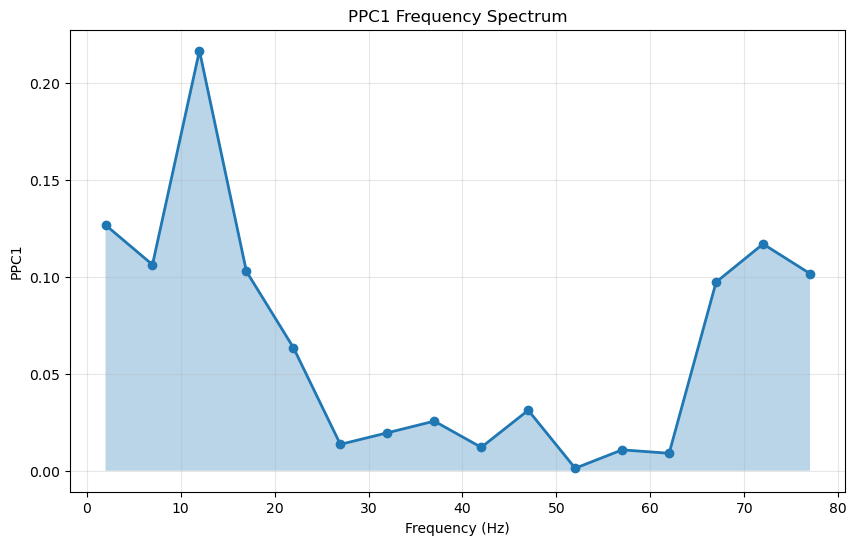

In [34]:
freqs, ppc1s = calculate_ppc1_spectrum(spike_rate['LTS'],lfp_processed[0],fs=400, freq_range=freq_range, freq_step=freq_step, bandwidth=bandwidth)
# Plot the spectrum
plot_ppc1_spectrum(freqs, ppc1s, title="PPC1 Frequency Spectrum")